In [10]:
import sys  
sys.path.insert(0, './../')
import bbdc2021
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras import layers, Sequential
from keras.models import Model
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
X_train_orig, Y_train_orig, timepoints, df = bbdc2021.load_data("/dataset_fft/dev-labels.csv", 'dataset_fft')
X_train_orig = np.array(X_train_orig)
Y_train_orig = np.array(Y_train_orig)

In [3]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_orig, Y_train_orig, test_size=0.33, random_state=42)

In [4]:
# cropping for unet to work, not ideal solution
X_train_c = X_train[:, :-1, :]
Y_train_c = Y_train[:, :-1, :]
X_val_c = X_val[:, :-1, :]
Y_val_c = Y_val[:, :-1, :]

In [15]:
def conv1d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = layers.Conv1D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # second layer
    x = layers.Conv1D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x
  
def unet(input_data, n_filters=16, dropout=0.1, batchnorm=True):
    input_layer = layers.Input(shape=(input_data[0].shape))
    
    # Contracting Path
    c1 = conv1d_block(input_layer, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = layers.MaxPooling1D(2)(c1)
    p1 = layers.Dropout(dropout)(p1)
    
    c2 = conv1d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = layers.MaxPooling1D(2)(c2)
    p2 = layers.Dropout(dropout)(p2)
    
    c3 = conv1d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = layers.MaxPooling1D(2)(c3)
    p3 = layers.Dropout(dropout)(p3)
    
    c4 = conv1d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = layers.MaxPooling1D(2)(c4)
    p4 = layers.Dropout(dropout)(p4)
    
    c5 = conv1d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive Path
    u6 = layers.Conv1DTranspose(n_filters * 8, 3, strides=2, padding='same')(c5)
    print(u6.shape)
    u6 = layers.concatenate([u6, c4])
    print(u6.shape)
    u6 = layers.Dropout(dropout)(u6)
    c6 = conv1d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = layers.Conv1DTranspose(n_filters * 4, 3, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout)(u7)
    c7 = conv1d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = layers.Conv1DTranspose(n_filters * 2, 3, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout)(u8)
    c8 = conv1d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = layers.Conv1DTranspose(n_filters * 1, 3, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropout)(u9)
    c9 = conv1d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = layers.Conv1D(13, 1, activation='softmax')(c9)
    return Model(inputs=input_layer, outputs=outputs)

In [16]:
model = unet(X_train_c, batchnorm=False)
model.summary()

(None, 26, 128)
(None, 26, 256)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 208, 17)]    0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 208, 16)      832         input_2[0][0]                    
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 208, 16)      0           conv1d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 104, 16)      0           activation_19[0][0]              
_______________________________________________________

In [14]:
#Mit crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae'])
history = model.fit(np.array(X_train_c),np.array(Y_train_c), batch_size=32, epochs=40, validation_data=(X_val_c, Y_val_c))

Epoch 1/40
210/210 [==============================] - 12s 55ms/step - loss: 6.9034 - mae: 0.0659 - val_loss: 6.9711 - val_mae: 0.0665
Epoch 2/40
210/210 [==============================] - 12s 57ms/step - loss: 6.9034 - mae: 0.0659 - val_loss: 6.9711 - val_mae: 0.0665
Epoch 3/40
210/210 [==============================] - 11s 53ms/step - loss: 6.9034 - mae: 0.0659 - val_loss: 6.9711 - val_mae: 0.0665
Epoch 4/40
210/210 [==============================] - 11s 53ms/step - loss: 6.9034 - mae: 0.0659 - val_loss: 6.9711 - val_mae: 0.0665
Epoch 5/40
210/210 [==============================] - 11s 53ms/step - loss: 6.9034 - mae: 0.0659 - val_loss: 6.9711 - val_mae: 0.0665
Epoch 6/40
210/210 [==============================] - 11s 53ms/step - loss: 6.9034 - mae: 0.0659 - val_loss: 6.9711 - val_mae: 0.0665
Epoch 7/40
210/210 [==============================] - 11s 53ms/step - loss: 6.9034 - mae: 0.0659 - val_loss: 6.9711 - val_mae: 0.0665
Epoch 8/40
210/210 [==============================] - 11s 53ms

KeyboardInterrupt: 

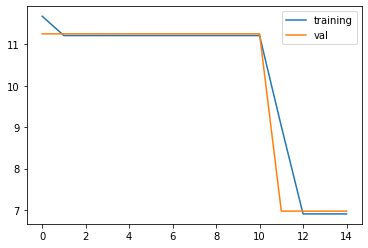

In [13]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()